In [2]:
import pandas as pd
import numpy as np
import string
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import csv

In [3]:
train = pd.read_csv('train_2.csv')
test = pd.read_csv('test_2.csv')

train.head()

,input,target
0,Ya. Next week coming.,Ya. Next week coming.
1,Yeah wana save n stinge... We shall eat smting...,"Yes, I want to save and stinge. We shall eat s..."
2,"Dunno how come cannot go online leh, tt fuji...",I don't know how come I cannot go online. That...
3,Hey come online? We discuss eng with regina,Can you come online? We shall discuss Eng with...
4,Ü all go then i go lor... Free one wat...,All go then I go. It is free.


In [4]:
input_lengths = []
target_lengths = []
for i, row in train.iterrows():
  input_lengths.append(len(row['input']))
  target_lengths.append(len(row['target']))


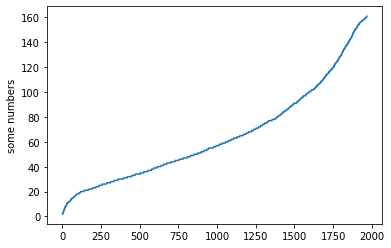

In [5]:
import matplotlib.pyplot as plt
x_value = range(len(input_lengths))
y_value = sorted(input_lengths)
plt.plot(x_value , y_value)
plt.ylabel('some numbers')
plt.show()

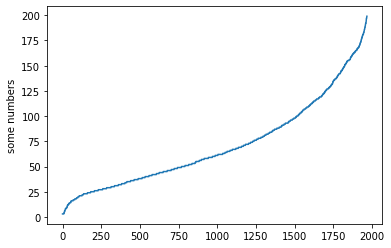

In [ ]:
x_value = range(len(target_lengths))
y_value = sorted(target_lengths)
plt.plot(x_value , y_value)
plt.ylabel('some numbers')
plt.show()

In [ ]:
train['input_lengths'] = input_lengths
train['target_lengths'] = target_lengths

In [ ]:
train = train[train['input_lengths'] < 500]
train = train[train['target_lengths'] < 500]

In [ ]:
train = train.drop(['input_lengths', 'target_lengths'], axis=1)


In [6]:
required_chars = []
for char in string.printable:
  if ord(char) > 31 and ord(char) < 126:
    required_chars.append(char)


print(len(required_chars))
print(required_chars)

94
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', ' ']


In [7]:
# Create a dictionary of chars and index value from 1. 0 is reserved for padding by the tokenizer.
vocabulary = dict()
for i in range(len(required_chars)):
  vocabulary[required_chars[i]] = i+1

In [8]:
# Use \t as Start of Sentence and \n as End of Sentence
vocabulary['\n'] = 95
vocabulary['\t'] = 96

In [9]:
# Characters that were found in train and test set and replaced with the normal english characters.
replacements = {'£':'', 'É': 'E', 'Ñ': 'N', 'Ü': 'U', 'à': 'a', 'ä': 'a', 'å': 'a', 'è': 'e', 'é': 'e', 'ì': 'i', 'ñ': 'n', 'ò': 'o', 'ö': 'o', 'ø': 'o', 'ù': 'u', 'ü': 'u',  '“': '"',  '”': '"',   '，': ',',   '？': '?' }

In [10]:
for old_char, new_char in replacements.items():
  train = train.replace(old_char, new_char, regex=True)
  test = test.replace(old_char, new_char, regex=True)

In [ ]:
# gen_sen_train = []
# target_sen_train = []
# gen_sen_test = []
# target_sen_test = []

# from textblob import TextBlob
# from tqdm import tqdm

# for i, row in tqdm(train.iterrows()):
#     textBlb = TextBlob(row['input'])
#     textCorrected = textBlb.correct() 
#     gen_sen_train.append(str(textCorrected))
#     target_sen_train.append(row['target'])

# for i, row in tqdm(test.iterrows()):
#     textBlb = TextBlob(row['input'])
#     textCorrected = textBlb.correct() 
#     gen_sen_test.append(str(textCorrected))
#     target_sen_test.append(row['target'])


In [ ]:
# train = pd.DataFrame({
#     'input':gen_sen_train,
#     'target':target_sen_train
# })

# test = pd.DataFrame({
#     'input':gen_sen_test,
#     'target':target_sen_test
# })

In [11]:
train['input'] = train['input'].replace({'..':'.', '...':'.', '???':'?', '??':'?', '#':'', "!!":"!","!!!":"!","@":"","$":"","%":"","^":"","&":"","(":"",")":"","_":"", ";":""})

In [12]:
for i, row in train.iterrows():
    value = row['input']
    repl_value = re.sub(r'\.+', ".", value)
    repl_value = re.sub(r'\!+', "!", repl_value)
    repl_value = re.sub(r'\ +', " ", repl_value)
    train.at[i,'input'] = repl_value

for i, row in test.iterrows():
    value = row['input']
    repl_value = re.sub(r'\.+', ".", value)
    repl_value = re.sub(r'\!+', "!", repl_value)
    repl_value = re.sub(r'\ +', " ", repl_value)
    test.at[i,'input'] = repl_value

In [13]:
train.head()

,input,target
0,Ya. Next week coming.,Ya. Next week coming.
1,Yeah wana save n stinge. We shall eat smting g...,"Yes, I want to save and stinge. We shall eat s..."
2,"Dunno how come cannot go online leh, tt fuji.",I don't know how come I cannot go online. That...
3,Hey come online? We discuss eng with regina,Can you come online? We shall discuss Eng with...
4,U all go then i go lor. Free one wat.,All go then I go. It is free.


In [14]:
# Adding the \t and \n as part of start and end of sentence
train['target_ip'] = '\t' + train['target'].astype(str)
train['target_op'] =  train['target'].astype(str) + '\n'

test['target_ip'] = '\t' + test['target'].astype(str)
test['target_op'] =  test['target'].astype(str) + '\n'

In [15]:
train = train.drop(['target'], axis=1)
test = test.drop(['target'], axis=1)

In [16]:
train.head()

,input,target_ip,target_op
0,Ya. Next week coming.,\tYa. Next week coming.,Ya. Next week coming.\n
1,Yeah wana save n stinge. We shall eat smting g...,"\tYes, I want to save and stinge. We shall eat...","Yes, I want to save and stinge. We shall eat s..."
2,"Dunno how come cannot go online leh, tt fuji.",\tI don't know how come I cannot go online. Th...,I don't know how come I cannot go online. That...
3,Hey come online? We discuss eng with regina,\tCan you come online? We shall discuss Eng wi...,Can you come online? We shall discuss Eng with...
4,U all go then i go lor. Free one wat.,\tAll go then I go. It is free.,All go then I go. It is free.\n


In [17]:
train.iloc[0]['target_ip']= str(train.iloc[0]['target_ip'])+'\n'
train.iloc[0]['target_op']= str(train.iloc[0]['target_op'])+'\n'

In [18]:
# Calculating the maximum length of among all the sentences which will be useful for padding.
max_length_encoder = train['input'].map(len).max()

print(max_length_encoder)

161


In [19]:
max_length_decoder = max( train['target_ip'].map(len).max(), train['target_op'].map(len).max())
print(max_length_decoder)

200


In [20]:
# Tokenizer for the raw input and target output
tokenizer_raw_ip = Tokenizer(
    char_level=True,
    lower=False,
    filters=None
)

tokenizer_target_ip = Tokenizer(
    char_level=True,
    lower=False,
    filters=None
)

In [21]:
tokenizer_raw_ip.fit_on_texts(train['input'].values)
tokenizer_target_ip.fit_on_texts(train['target_ip'].values)

In [22]:
# Replacing the vocabulary of the trained index to a vocabulary mentioned in the research paper
tokenizer_target_ip.word_index = vocabulary
tokenizer_raw_ip.word_index = vocabulary

In [23]:
target_vocab_size=len(tokenizer_target_ip.word_index.keys())
print(target_vocab_size)
input_vocab_size=len(tokenizer_raw_ip.word_index.keys())
print(input_vocab_size)

96
96


In [66]:
# Encoder class with Embedding layer and LSTM layer.
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, enc_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Embedding_Layer_Encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, name="Encoder_LSTM")
        # self.lstm_2 = LSTM(self.enc_units, return_state=True, name="Encoder_LSTM_2")
        # self.lstm_3 = LSTM(self.enc_units, return_state=True, name="Encoder_LSTM_3")
        # self.lstm_4 = LSTM(self.enc_units, return_state=True, name="Encoder_LSTM_4")

        
    def call(self, input_sentances, training=True):
        
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_sentances)
#         self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm_2(self.lstm_output)
#         self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm_3(self.lstm_output)
#         self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm_4(self.lstm_output)


        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c
    
# Decoder class with embedding and LSTM layer.    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.input_length = input_length
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Embedding_Layer_Decoder",)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM")
        # self.lstm_2 = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM_2")
        # self.lstm_3 = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM_3")
        # self.lstm_4 = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM_4")
    
    def call(self, target_sentences, state_h, state_c):
        
        lstm_output, _,_        = self.lstm(target_sentences, initial_state=[state_h, state_c])
        # lstm_output, _,_        = self.lstm_2(lstm_output, initial_state=[state_h, state_c])
        # lstm_output, _,_        = self.lstm_3(lstm_output, initial_state=[state_h, state_c])
        # lstm_output, _,_        = self.lstm_4(lstm_output, initial_state=[state_h, state_c])

        return lstm_output

In [25]:
# Creating a data pipeline
class Dataset:
    def __init__(self, data, tokenizer_raw_ip, tokenizer_target_ip, max_length_encoder,max_length_decoder):
        self.encoder_inps = data['input'].values
        self.decoder_inps = data['target_ip'].values
        self.decoder_outs = data['target_op'].values
        self.tokenizer_target_ip = tokenizer_target_ip
        self.tokenizer_raw_ip = tokenizer_raw_ip
        self.max_length_encoder = max_length_encoder
        self.max_length_decoder = max_length_decoder

    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_raw_ip.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tokenizer_target_ip.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_target_ip.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_length_encoder, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_length_decoder, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_length_decoder, dtype='int32', padding='post')

        self.encoder_seq = tf.keras.utils.to_categorical(self.encoder_seq, num_classes=len(tokenizer_raw_ip.word_index.keys())+1)
        self.decoder_inp_seq = tf.keras.utils.to_categorical(self.decoder_inp_seq, num_classes=len(tokenizer_target_ip.word_index.keys())+1)
        self.decoder_out_seq = tf.keras.utils.to_categorical(self.decoder_out_seq, num_classes=len(tokenizer_target_ip.word_index.keys())+1)

        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
            
        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [26]:
train_dataset = Dataset(train, tokenizer_raw_ip, tokenizer_target_ip, max_length_encoder, max_length_decoder)
test_dataset  = Dataset(test, tokenizer_raw_ip, tokenizer_target_ip, max_length_encoder, max_length_decoder)

In [27]:
train_dataloader = Dataloder(train_dataset, batch_size=64)
test_dataloader = Dataloder(test_dataset, batch_size=20)

print(train_dataloader[1][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 161, 97) (64, 200, 97) (64, 200, 97)


In [41]:
# Model 1 - 1 layer LSTM model for each encoder and decoder
class Model1(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(vocab_size=input_vocab_size+1, embedding_dim=50, input_length=encoder_inputs_length, enc_units=100)
        self.decoder = Decoder(vocab_size=target_vocab_size+1, embedding_dim=50, input_length=decoder_inputs_length, dec_units=100)
        self.dense   = Dense(output_vocab_size+1, activation='softmax')
        
    def call(self, data):
        input,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input)
        decoder_output                       = self.decoder(output, encoder_h, encoder_c)
        output                               = self.dense(decoder_output)
        return output        

In [47]:
# Reduce learning rate based on the validation loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.99, verbose=1, mode='min', min_lr=0.0001)

In [48]:
checkpoint_filepath = 'model_1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [52]:
model  = Model1(encoder_inputs_length=max_length_encoder,decoder_inputs_length=max_length_decoder,output_vocab_size=target_vocab_size)

In [ ]:
# Do once normal loss function works
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def custom_lossfunction(real, pred):

  # Custom loss function that will not consider the loss for padded zeros.
  # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
  
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [53]:
# Using Adam and Gradient clipping to prevent gradient explosion as mentioned in the research paper
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy')
train_steps=train.shape[0]//64
valid_steps=test.shape[0]//20 


In [54]:
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=200,  validation_data=test_dataloader, validation_steps=valid_steps, callbacks=[reduce_lr, model_checkpoint_callback])
model.summary()

Epoch 1/200
30/30 [==============================] - 4s 60ms/step - loss: 3.7757 - val_loss: 1.3952
Epoch 2/200
30/30 [==============================] - 1s 39ms/step - loss: 1.6538 - val_loss: 1.0314
Epoch 3/200
30/30 [==============================] - 1s 39ms/step - loss: 1.2648 - val_loss: 0.9008
Epoch 4/200
30/30 [==============================] - 1s 40ms/step - loss: 1.1970 - val_loss: 0.8636
Epoch 5/200
30/30 [==============================] - 1s 40ms/step - loss: 1.1760 - val_loss: 0.8459
Epoch 6/200
30/30 [==============================] - 1s 39ms/step - loss: 1.1676 - val_loss: 0.8293
Epoch 7/200
30/30 [==============================] - 1s 40ms/step - loss: 1.1295 - val_loss: 0.8153
Epoch 8/200
30/30 [==============================] - 1s 40ms/step - loss: 1.1308 - val_loss: 0.7995
Epoch 9/200
30/30 [==============================] - 1s 40ms/step - loss: 1.1125 - val_loss: 0.7821
Epoch 10/200
30/30 [==============================] - 1s 40ms/step - loss: 1.1086 - val_loss: 0.7621

In [55]:
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=200,  validation_data=test_dataloader, validation_steps=valid_steps, callbacks=[reduce_lr, model_checkpoint_callback])
model.summary()

Epoch 1/200
30/30 [==============================] - 1s 41ms/step - loss: 0.5117 - val_loss: 0.3777
Epoch 2/200
30/30 [==============================] - 1s 39ms/step - loss: 0.5104 - val_loss: 0.3776
Epoch 3/200
30/30 [==============================] - 1s 39ms/step - loss: 0.5099 - val_loss: 0.3776
Epoch 4/200
30/30 [==============================] - 1s 40ms/step - loss: 0.5092 - val_loss: 0.3773
Epoch 5/200
30/30 [==============================] - 1s 40ms/step - loss: 0.5090 - val_loss: 0.3757
Epoch 6/200
30/30 [==============================] - 1s 39ms/step - loss: 0.5083 - val_loss: 0.3774
Epoch 7/200
30/30 [==============================] - 1s 40ms/step - loss: 0.5071 - val_loss: 0.3756
Epoch 8/200
30/30 [==============================] - 1s 40ms/step - loss: 0.5059 - val_loss: 0.3764
Epoch 9/200
30/30 [==============================] - 1s 41ms/step - loss: 0.5056 - val_loss: 0.3765
Epoch 10/200
30/30 [==============================] - 1s 40ms/step - loss: 0.5050 - val_loss: 0.3764

In [58]:
model.load_weights("model_1")

In [59]:
model.evaluate(test_dataloader)

1/1 [==============================] - 0s 47ms/step - loss: 0.3711


0.371053010225296

In [ ]:
model.save_weights('./model_1/model_novel_1')

In [60]:
print("The validation loss of the model 1 is:", 0.3711)
print("The perplexity of the model 1 is:", 2**(0.3711))

The validation loss of the model 1 is: 0.3711
The perplexity of the model 1 is: 1.2933385761793754


In [61]:
start_index = tokenizer_target_ip.word_index['\t']
end_index = tokenizer_target_ip.word_index['\n']
DECODER_SEQ_LEN = max_length_decoder
max_len = max_length_decoder


def predict(input_sentence):

  encoder_seq = tokenizer_raw_ip.texts_to_sequences([input_sentence])

  encoder_seq = pad_sequences(encoder_seq, maxlen=max_length_encoder, dtype='int32', padding='post')

  encoder_seq = tf.keras.utils.to_categorical(encoder_seq, num_classes=len(tokenizer_raw_ip.word_index.keys())+1)

  enc_output, enc_state_h, enc_state_c = model.layers[0](encoder_seq)
  
  # enc_output, enc_state_h, enc_state_c = model.layers[0].lstm_2(enc_output)
  # enc_output, enc_state_h, enc_state_c = model.layers[0].lstm_3(enc_output)
  # enc_output, enc_state_h, enc_state_c = model.layers[0].lstm_4(enc_output)

  dec_input = np.zeros((1, 1, len(tokenizer_raw_ip.word_index.keys())+1))

  dec_input[0, 0, tokenizer_target_ip.word_index['\t']] = 1.

  input_state = [enc_state_h, enc_state_c]

  output_word = []

  for i in range(DECODER_SEQ_LEN):
      # cur_emb = model.layers[1].embedding(dec_input)

      predicted_out, state_h, state_c = model.layers[1].lstm(dec_input, input_state)

      # predicted_out, state_h, state_c = model.layers[1].lstm_2(predicted_out, input_state)
      # predicted_out, state_h, state_c = model.layers[1].lstm_3(predicted_out, input_state)
      # predicted_out, state_h, state_c = model.layers[1].lstm_4(predicted_out, input_state)

      dense_layer_out = model.layers[2](predicted_out)

      input_state = [state_h, state_c]
  
      output_word_index = np.argmax(dense_layer_out)

      # print(output_word_index)

      for key, value in tokenizer_target_ip.word_index.items():

         if output_word_index == value:
             output_word.append(key)

      dec_input = np.reshape(output_word_index, (1, 1))

      dec_input = np.zeros((1, 1, len(tokenizer_raw_ip.word_index.keys())+1))

      dec_input[0, 0, output_word_index] = 1.


      if output_word_index == tokenizer_target_ip.word_index['\n']:
        break
  return output_word


In [62]:
predicted_sentences = []
actual_sentences = []

for i, row in test.iterrows():
    output = predict(row['input'])
    predicted_sentences.append(output)
    english_out = row['target_op'].split()
    actual_sentences.append(english_out)
    sentence = ''.join(output)
    print('Input Sentence:',row['input'])
    print('Predicted Sentence:',sentence)
    print('Original English sentence:', row['target_op'])
    print('*'*30)

Input Sentence: Mmm thats better now i got a roast down me! i'd b better if i had a few drinks down me 2! Good indian?
Predicted Sentence: Hey, I want to go to chat with you to stay only to chat with you to come to come at 1:30pm. I haven't see you all the show?

Original English sentence: That's better now, I got a roast down me! I'd be better if I had a few drinks down me too! Good Indian?

******************************
Input Sentence: Watch wat?
Predicted Sentence: Haha. I am not going to see you.

Original English sentence: Watch what?

******************************
Input Sentence: Oh dat.hehe.Why r u so interested?
Predicted Sentence: Hey, I don't know where are you free tomorrow?

Original English sentence: Oh that. Hehe. Why are you so interested?

******************************
Input Sentence: hai
Predicted Sentence: Hey.

Original English sentence: Hi.

******************************
Input Sentence: ask more abt me?
Predicted Sentence: Hey, I want to go to see you.

Original

In [63]:
from nltk.translate.bleu_score import sentence_bleu
avg_score = 0
for i in range(len(actual_sentences)):
    score = sentence_bleu([actual_sentences[i]], predicted_sentences[i])
    avg_score += score

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [64]:
print("Avg BLEU Score of Simple Encoder Decoder Model:", (avg_score/(len(actual_sentences))))

Avg BLEU Score of Simple Encoder Decoder Model: 0.09079140153883539
